# Bag of Words EDA

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Supress the unnumbered hordes of warnings that make output completely unreadable
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The data isn't a nicely formatted CSV file, so at this point I'll have to 'read the manual' to figure out how to load it. 

### Read the manual

>Data Set Characteristics: Text
...
Attribute Characteristics: Integer
...
Associated Tasks: Clustering
Missing Values? N/A

The data is text data, there is also numeric (integer) data, clustering is a suggested approach, and there are no missing data.

>D is the number of documents, W is the
number of words in the vocabulary, and N is the total number of words
in the collection 

For each dataset, there is acount of the number of documents, there is a count of the number of discrete words, and there is a count of the total number of words. 

>After tokenization and removal of stopwords, the
vocabulary of unique words was truncated by only keeping words that
occurred more than ten times

The words were tokenised, which explains the integer data. Stopwords were removed, so some noise has already been removed from the dataset. Only words that were used 10+ times in a datset will be counted within the documents of that dataset, which again removes noise that can't be usefully learnt from (if a word is only used once in one document, how can a model learn usefully from that for predicting other documents?)

>These data sets have no class labels, and for copyright reasons no
filenames or other document-level metadata.  These data sets are ideal
for clustering and topic modeling experiments.

There are no class labels, so there will be no supervised learning. Clustering is suggested again. 

>For each text collection we provide docword.*.txt (the bag of words
file in sparse format) and vocab.*.txt (the vocab file).

The data comes in two separate files. One has the counts, and one has the actual words. 

>Enron Emails:  
orig source: www.cs.cmu.edu/~enron  
D=39861  
W=28102  
N=6,400,000 (approx)

There are ~40,000 data samples, ~28,000 features (discrete words), and ~6,400,000 words in total. Given the possible amount of data is 93861\*28192=1,120,173,822, and 6400000/1120173822=0.57%, which makes this a _very_ sparse dataset. 

>(below, NNZ is the number of nonzero counts in the
bag-of-words)  

>The format of the docword.*.txt file is 3 header lines, followed by NNZ triples:  
---  
D  
W  
NNZ  
docID wordID count

I should remove the first three lines of the file when reading it in, and add them manually as column headers. 

>The format of the vocab.*.txt file is line contains wordID=n.

Assuming n is line number, then that explains the key between docword files and vocab files. It doesn't tell me if that count starts from zero or one, so I'll have to check if zeros appear in the docword data once loaded. 

So, the data is awkwardly arranged and very sparse. 

In [2]:
# Data loading
docword_column_names = ['docID', 'wordID', 'count']
docword_data = pd.read_csv('../input/docword.enron.txt', delim_whitespace=True, header=None, skiprows=3, names=docword_column_names)
vocab_column_names = ['word']
vocab_data = pd.read_csv('../input/vocab.enron.txt', delim_whitespace=True, header=None, names=vocab_column_names)

In [3]:
# Lets take a look at random samples of the datasets. For the sake of presentation each will be in it's own cell. 
docword_data.sample(5, random_state=4)

,docID,wordID,count
463546,6215,16538,1
1513672,22251,26042,1
2183547,28113,12037,1
423124,5811,24206,1
3214446,33983,5007,1


The data appears to be as described, integer numerical data, with docID and wordID being nominal categorical data, and count being discrete ratio data. 

In [4]:
vocab_data.sample(5, random_state=4)

,word
24695,tahomaarial
24097,street
15783,mexicos
14723,longrun
8018,eliminating


Again, this all appears to be as described, and is obviously nominal categorical data. 

In [5]:
# Descriptive statistics
docword_data.describe()

,docID,wordID,count
count,3.710420e+06,3.710420e+06,3.710420e+06
mean,2.268149e+04,1.393388e+04,1.728153e+00
std,1.094254e+04,8.020984e+03,2.565260e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.403200e+04,6.808000e+03,1.000000e+00
50%,2.557000e+04,1.415600e+04,1.000000e+00
75%,3.168300e+04,2.083500e+04,2.000000e+00
max,3.986100e+04,2.810200e+04,4.030000e+02


While not the easiest to read, the above statistical description does confirm that the wordID does not start from zero, there are 39861 documents and 28102 discrete words. Also interesting to note, is that while the minimum number of times a word appears in a document is one, and the mean is 1.728, and the 75% is two, the max is 403, which is (relatively) a huge number. 

In [6]:
vocab_data.describe()

,word
count,28101
unique,28101
top,enforceability
freq,1


Of limited use, this at least confirms that there are 28102 discrete words (shown as 28101 because it started counting from zero).  
That means there'll be an off-by-one error for all the references between the two data structures.  

###### Note 
It should be noted that the data in this dataset, while it will be treated as if it's features are independent, doesn't not actually have independent variables. The occurence of one word is dependent on the occurence or lack of occurent of other words preceeding it in a sentence. 

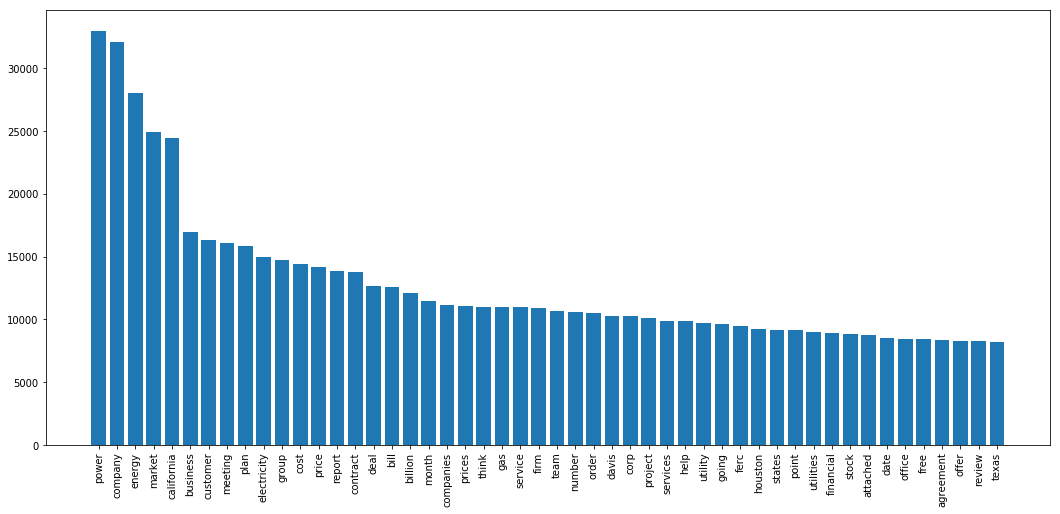

In [7]:
word_counts = docword_data[['wordID', 'count']].groupby('wordID').sum()
sorted_counts = word_counts.sort_values('count', ascending=False)
high_word_counts =  sorted_counts[0:50]

f = lambda x: x-1
high_word_indexes = high_word_counts.index.tolist()
high_word_indexes[:] = [x - 1 for x in high_word_indexes]
most_common_words = vocab_data.iloc[high_word_indexes]['word'].values.tolist()
most_common_word_counts = high_word_counts.iloc[0:50,:]['count'].values.tolist()

fig_1, ax_1 = plt.subplots(figsize=(18,8))
ax_1.bar(most_common_words, most_common_word_counts)
plt.xticks(rotation='vertical');

The most common words occur thousands of times more than any word after them, and even then the most common two words occur as many times more than the fifth most common word, as that word does the sixth.  
The 21 top words are all nouns, or can be used as nouns. The 22nd word; 'think', is the most common word that isn't a noun. 

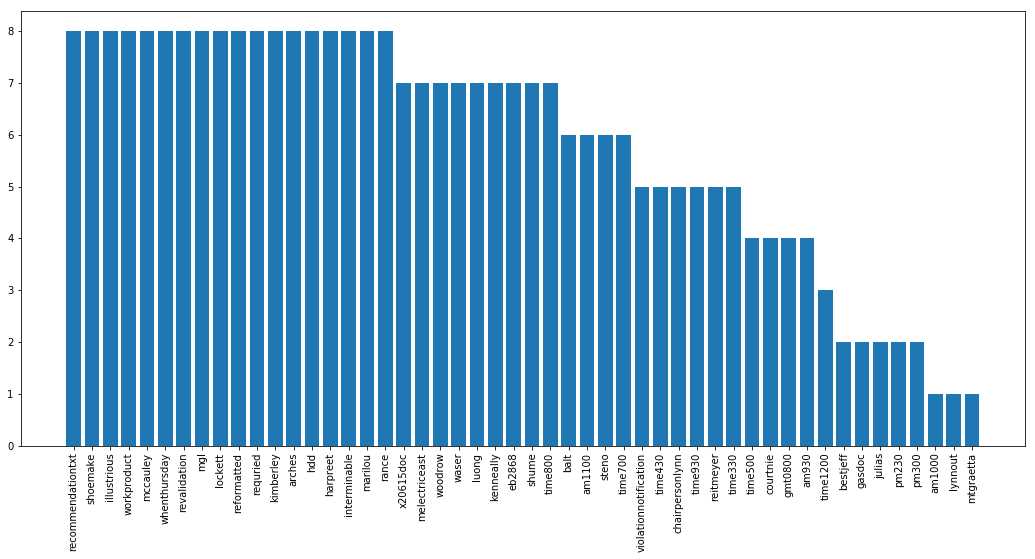

In [8]:
low_word_counts =  sorted_counts[-50:]

f = lambda x: x-1
low_word_indexes = low_word_counts.index.tolist()
low_word_indexes[:] = [x - 1 for x in low_word_indexes]
least_common_words = vocab_data.iloc[low_word_indexes]['word'].values.tolist()
least_common_word_counts = low_word_counts.iloc[0:50,:]['count'].values.tolist()

fig_2, ax_2 = plt.subplots(figsize=(18,8))
ax_2.bar(least_common_words, least_common_word_counts)
plt.xticks(rotation='vertical');

There are three words that occur only once in the entire dataset; 'am1000', 'lynnout', 'mtgraetta'. A lot of the least comon words look like misspellings and typos. 

In [9]:
# Length of emails
number_of_words_in_documents = docword_data['docID'].value_counts().sort_index()

number_of_words_in_documents.describe()

count    39861.000000
mean        93.083967
std        189.834616
min          2.000000
25%         22.000000
50%         42.000000
75%         87.000000
max       2120.000000
Name: docID, dtype: float64

In [10]:
stats.describe(number_of_words_in_documents)

DescribeResult(nobs=39861, minmax=(2, 2120), mean=93.0839667845764, variance=36037.181333747416, skewness=6.3306948196075785, kurtosis=48.167241077437176)

The range of lengths of emails is huge, ranging from two (which I assume has many uncommon words removed), to 2120, which is _huge_. I'm guessing it contained some sort of very long report? Or was some sort of conversation where the reply contains the initial message, and then the reply to that contains the inital message and the first reply, and so on? The size of the largest emails is incredible from my experience of working in a corporate environment, and it screams outlier to me. Further analysis is obviously necessary. 

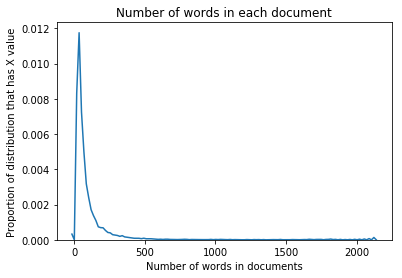

In [11]:
ax_single = sns.distplot(number_of_words_in_documents, hist=False)
ax_single.set(title='Number of words in each document', xlabel='Number of words in documents', ylabel='Proportion of distribution that has X value');

In [12]:
number_of_words_in_documents.loc[number_of_words_in_documents > 500].size

945

Only 2.4% of the emails. Even so, over 500 words? I don't think I've ever written a single email of 500 words at work. Unless they're sending whole reports in the body of emails? Given the preprocessing done to this dataset prior to me getting it, I don't think I'll be able to find out here. I have heard that the original dataset is still available, so maybe I'll find out in a future analysis. 

As for the rest of the numbers; there is significant skew and huge kurtosis, and the mean is more than twice the 50th percentile. Given that 2.4% of the emails are unusually long, it is possible that the mean has been skewed, since half the emails are in the 22-78 range. 

Before I graph this to see it, I'm just curious as to how much of the data-space has actual data in it, and how much is empty (how much of it is zero). 

In [13]:
### Total data-space = number of documents * number of words
data_space = docword_data['docID'].max() * vocab_data.size
data_volume = docword_data.groupby('docID')['wordID'].count().sum()

print('Total data-space: {}'.format(data_space))
print('Total data: {}'.format(data_volume))
print('Percentage of data-space filled with data: {}%'.format('%0.3f' % ((data_volume/data_space)*100)))
print('Percentage of data-space left empty: {}%'.format('%0.3f' % ((1-(data_volume/data_space))*100)))

Total data-space: 1120173822
Total data: 3710420
Percentage of data-space filled with data: 0.331%
Percentage of data-space left empty: 99.669%


There's a lot of data, and it takes up nearly none of the space it exists in. 

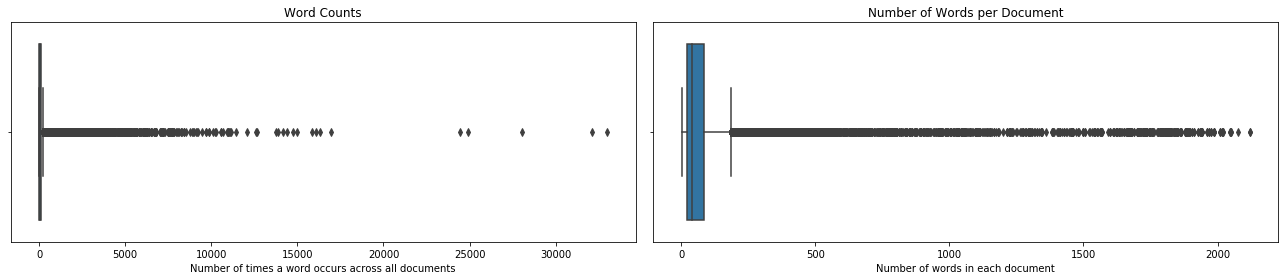

In [14]:
# Outlier visualisation - inclusion
fig_3, ax_3 = plt.subplots(1,2,figsize=(18,4))

sns.boxplot(x='count', data=word_counts, ax=ax_3[0])
sns.boxplot(x=number_of_words_in_documents.data, data=number_of_words_in_documents, ax=ax_3[1])

ax_3[0].set(title='Word Counts', xlabel='Number of times a word occurs across all documents')
ax_3[1].set(title='Number of Words per Document', xlabel='Number of words in each document')

fig_3.tight_layout()

Obviously, there is some serious imbalance here, that makes this difficult to see. Since this is ratio data, the hard lower limit of zero means there's only one way to tail, and the right hand tails are huge here. If I remove them, and show box plots of what's left: 

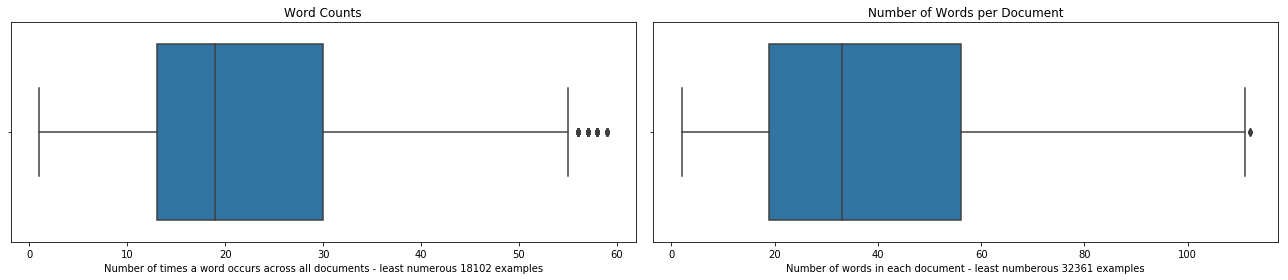

In [15]:
# Outlier visualisation - exclusion
fig_4, ax_4 = plt.subplots(1,2,figsize=(18,4))

subset_of_word_counts = word_counts.sort_values(by='count', ascending=False)[10000:]
subset_of_number_of_words_in_documents = number_of_words_in_documents.sort_values(ascending=False)[7500:]

sns.boxplot(x='count', data=subset_of_word_counts, ax=ax_4[0])
sns.boxplot(x=subset_of_number_of_words_in_documents.data, data=subset_of_number_of_words_in_documents, ax=ax_4[1])

ax_4[0].set(title='Word Counts', xlabel='Number of times a word occurs across all documents - least numerous 18102 examples')
ax_4[1].set(title='Number of Words per Document', xlabel='Number of words in each document - least numberous 32361 examples')

fig_4.tight_layout()

So without the tails, the boxplots look much more normal, so there are cores of more similar data, with a large amounts of rarer instances on the right tails. At this point, my normal EDA process runs out, as this data doesn't display comprehendably in scatter graphs or pairplots.  

Since there isn't really a good way to visualise very low density, very high dimensional data, I'll now move on to the analysis. 